# Markov Chains

In this script, we try to make a distinction between SBH and LBH. We will look at the frequency of function types and compare them between the books.

In [52]:
import glob, re, getpass, collections, operator, scipy.stats, sklearn.metrics
from itertools import chain
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from discreteMarkovChain import markovChain
from functions.bhsa import get_data, unique, lbh_books, sbh_books # <- here's the new data data load statement -CK

from numpy.polynomial import Polynomial
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import pearsonr 
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from numpy.linalg import norm

In [3]:
all_data = get_data()

# Functions

In [128]:
def transitionWalk1(clauses):
    states = list()
    for clause in clauses:
        states.append("Clause_Begin")
        states.extend(clause)
        states.append("Clause_End")
    return states

def transitionWalk2(clauses):
    return list(chain(*clauses))

def MarkovModel(transitionWalk):
    nodes = list(set(transitionWalk))
    transition_Matrix = np.zeros((len(nodes),len(nodes)))
    
    for i in range(0,len(transitionWalk)-1):
        transition_Matrix[nodes.index(transitionWalk[i]), nodes.index(transitionWalk[i+1])] +=1 
        
    df_Trans = pd.DataFrame(transition_Matrix, columns = nodes, index = nodes)    
    
     # Remove unused transition functions
    df_Trans = df_Trans[(df_Trans.T != 0).any()]
    df_Trans_Count = df_Trans.loc[:,(df_Trans != 0).any(axis=0)]
    
    df_Trans_Prob = df_Trans_Count.div(df_Trans_Count.sum(axis=1), axis=0) 
    
    return df_Trans_Count, df_Trans_Prob

def makeMarkovModels(data):
    df_Freq = dict()
    df_Prob = dict()
    
    for bookname, clauses in data.items():
        walk = transitionWalk2(clauses)
        df_Trans_Count, df_Trans_Prob = MarkovModel(walk)
        
        df_Freq[bookname] = df_Trans_Count
        df_Prob[bookname] = df_Trans_Prob
    return df_Freq, df_Prob

def MarkovChainSSP(df_Transition_prob, books):
    df_MC_SSP = pd.DataFrame()
    for bookname, transition in df_Transition_prob.items():

        P = np.matrix(transition.values)
        mc = markovChain(P)
        mc.computePi('linear') #We can also use 'power', 'krylov' or 'eigen', 'linear'
        
        dfSS = pd.DataFrame(list(mc.pi), index=transition.index, columns=[bookname])
        
        df_MC_SSP= pd.concat([dfSS,df_MC_SSP], axis=1)
        
    df_MC_SSP= df_MC_SSP.sort_index(axis=1)
    df_MC_SSP = df_MC_SSP.replace(np.nan,0.0)
    return df_MC_SSP   

def hellingerDistance(df_prob_M1,df_prob_M2):
    df1 = df_prob_M1.applymap(np.sqrt)
    df2 = df_prob_M2.applymap(np.sqrt)
    df_sub = df1.subtract(df2, fill_value=0)
    df_sub = df_sub.fillna(0.0)
    df_sub = np.power(df_sub, 2)
    sumDiff = np.sum(df_sub.values)
    helligerDistance = np.sqrt(sumDiff)/np.sqrt(2)
    return helligerDistance

def totalVariationDistance(df_prob_M1, df_prob_M2):
    df_sub = df_prob_M1.subtract(df_prob_M2, fill_value =0)
    df_sub = df_sub.fillna(0.0)
    maxVar = abs(df_sub.values).sum() *0.5
    return maxVar

def distanceMarkovTransitionMatrix(df_Prob, books):
    df_Dist = pd.DataFrame(np.zeros((len(books), len(books))), columns = books, index = books) 
    for indexi,i in enumerate(books):
        for indexj,j in enumerate(books):
            x = df_Prob[i]
            y = df_Prob[j]   
            df_Dist.loc[i,j] = hellingerDistance(x,y)
    return df_Dist
            
    
    
    

## Analysis

In [119]:
data = all_data['phrase_functions']
unique_functions = unique(otype='phrase', feature='function') # N.B., I've added back our excluded functions
print(unique_functions)

['Pred', 'Conj', 'Subj', 'Cmpl', 'Objc', 'PreC', 'Adju', 'Rela', 'Nega', 'PreO', 'Time', 'Modi', 'Loca', 'Intj', 'Voct', 'Ques', 'Frnt', 'PreS', 'NCop', 'IntS', 'PrAd', 'Supp', 'PtcO', 'Exst', 'NCoS', 'ModS', 'EPPr', 'ExsS', 'PrcS']


In [120]:
df_Freq, df_Prob = makeMarkovModels(data)
#df_Prob["Esther"]

In [121]:
MarkovSSP = MarkovChainSSP(df_Prob, data.keys())
#MarkovSSP

In [129]:
MarkovDistance = distanceMarkovTransitionMatrix(df_Prob, data.keys())
MarkovDistance

,Genesis,sbh,Exodus,Leviticus,Deuteronomy,Joshua,Judges,1_Samuel,2_Samuel,1_Kings,2_Kings,Esther,lbh,Ezra,Nehemiah,1_Chronicles,2_Chronicles
Genesis,0.000000,1.342735,2.198352,2.787601,2.634807,2.103538,1.775712,2.138744,2.094362,2.019113,1.877317,2.247436,1.874109,2.510136,2.344768,2.525004,2.381844
sbh,1.342735,0.000000,2.148457,2.843938,2.304003,2.107010,1.796646,1.978990,1.865342,1.754141,1.709577,2.273997,1.830422,2.587075,2.493642,2.533878,2.260525
Exodus,2.198352,2.148457,0.000000,2.409809,2.300792,2.115486,2.061556,2.316774,2.084821,2.447866,1.964054,2.249643,2.287522,2.390076,2.217108,2.475626,2.420483
Leviticus,2.787601,2.843938,2.409809,0.000000,2.385568,2.073437,2.667855,2.561513,2.686903,2.771338,2.702982,2.520241,2.920079,2.529245,2.570941,2.501424,2.602050
Deuteronomy,2.634807,2.304003,2.300792,2.385568,0.000000,2.134695,2.429144,2.508744,2.304106,2.644129,2.120020,2.595378,2.643735,2.658275,2.639603,2.697643,2.392374
Joshua,2.103538,2.107010,2.115486,2.073437,2.134695,0.000000,2.126246,2.048914,2.213495,2.047466,1.824195,2.289788,2.320945,2.224771,2.364959,2.066601,1.990999
Judges,1.775712,1.796646,2.061556,2.667855,2.429144,2.126246,0.000000,1.858920,1.926736,2.242604,1.971584,2.137569,2.055872,2.597486,2.114112,2.439966,2.350991
1_Samuel,2.138744,1.978990,2.316774,2.561513,2.508744,2.048914,1.858920,0.000000,2.143661,2.173076,2.315884,2.341788,2.512508,2.546918,2.580345,2.347177,2.425663
2_Samuel,2.094362,1.865342,2.084821,2.686903,2.304106,2.213495,1.926736,2.143661,0.000000,2.304460,2.125787,2.210239,2.298220,2.569258,2.584698,2.622692,2.489642
1_Kings,2.019113,1.754141,2.447866,2.771338,2.644129,2.047466,2.242604,2.173076,2.304460,0.000000,2.062121,2.284713,2.255838,2.520330,2.596893,2.287806,2.186606


C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


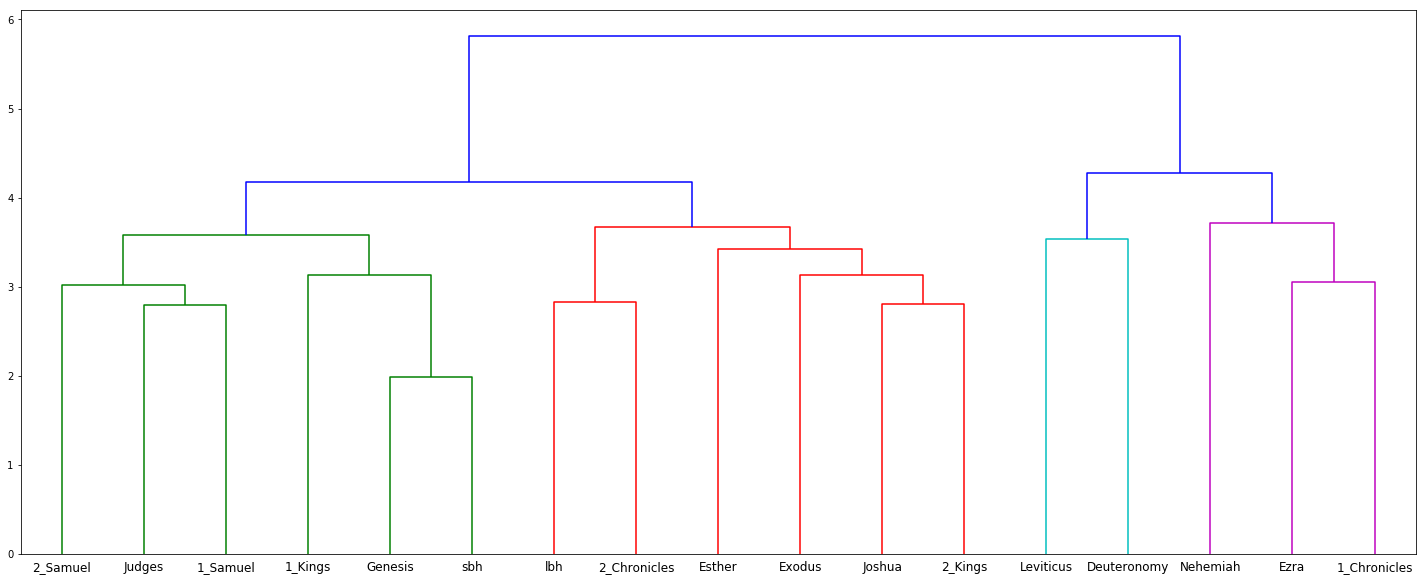

In [130]:
Z=linkage(np.matrix(MarkovDistance.values), 'ward')
plt.figure(figsize=(25,10))
dendrogram(Z, labels = list(data.keys()))
plt.show()